# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Deep-Learning-Approach-Vehicle-Detection" data-toc-modified-id="Deep-Learning-Approach-Vehicle-Detection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Deep Learning Approach Vehicle Detection</a></div><div class="lev2 toc-item"><a href="#Read-datasets" data-toc-modified-id="Read-datasets-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read datasets</a></div><div class="lev2 toc-item"><a href="#Build-a-model" data-toc-modified-id="Build-a-model-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Build a model</a></div><div class="lev2 toc-item"><a href="#Image-Augmentations" data-toc-modified-id="Image-Augmentations-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Image Augmentations</a></div><div class="lev2 toc-item"><a href="#Train-a-model" data-toc-modified-id="Train-a-model-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Train a model</a></div><div class="lev2 toc-item"><a href="#Save-a-model" data-toc-modified-id="Save-a-model-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Save a model</a></div><div class="lev2 toc-item"><a href="#ROI-Cropping" data-toc-modified-id="ROI-Cropping-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>ROI Cropping</a></div><div class="lev2 toc-item"><a href="#Build-a-heatmap-model-and-load-the-pretrained-weights" data-toc-modified-id="Build-a-heatmap-model-and-load-the-pretrained-weights-17"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Build a heatmap model and load the pretrained weights</a></div><div class="lev1 toc-item"><a href="#Pipeline" data-toc-modified-id="Pipeline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pipeline</a></div><div class="lev2 toc-item"><a href="#Pipeline-factory" data-toc-modified-id="Pipeline-factory-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Pipeline factory</a></div><div class="lev2 toc-item"><a href="#Pipeline-Test" data-toc-modified-id="Pipeline-Test-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pipeline Test</a></div><div class="lev2 toc-item"><a href="#Video" data-toc-modified-id="Video-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Video</a></div>

# Deep Learning Approach Vehicle Detection

In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing.pool import Pool
from sklearn.model_selection import train_test_split
from scipy.ndimage import label

%matplotlib inline

In [2]:
# Helper methods (not related to image features & transformations)
def plot_image(image, cmap="gray", **kwargs):
    """Plots an image"""
    shape = image.shape
    
    if len(shape) == 2:
        plt.imshow(image, cmap=cmap, **kwargs)
        
    else:
        plt.imshow(image, **kwargs)
        
        
def plot_two_images(image_A, title_A, image_B, title_B, figsize=(15, 10)):
    plt.figure(figsize=figsize)
    
    plt.subplot(1, 2, 1)
    plot_image(image_A)
    plt.title(title_A)
    
    plt.subplot(1, 2, 2)
    plot_image(image_B)
    plt.title(title_B)

In [3]:
car_path_list = glob.glob("training_images/vehicles/*/*", recursive=True)
nocar_path_list = glob.glob("training_images/non-vehicles/*/*", recursive=True)

labels = [1] * len(car_path_list) + [0] * len(nocar_path_list)
training_image_path_list = car_path_list + nocar_path_list

print("There are {:,} car images and {:,} no car images".format(len(car_path_list), len(nocar_path_list)))

There are 8,792 car images and 8,968 no car images


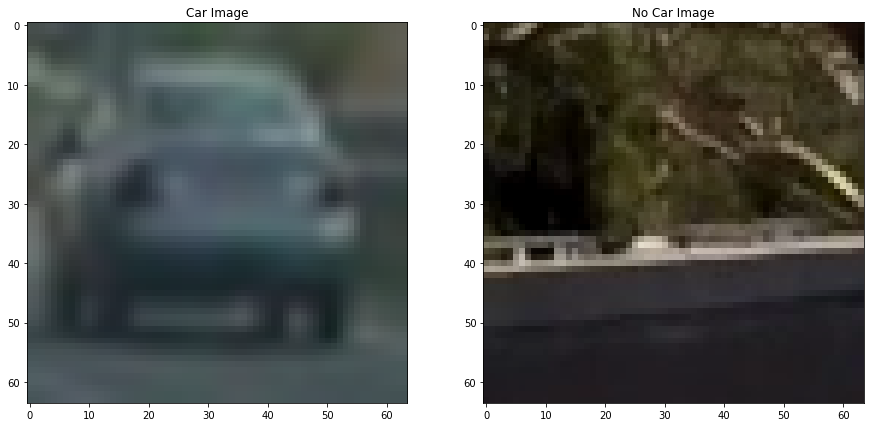

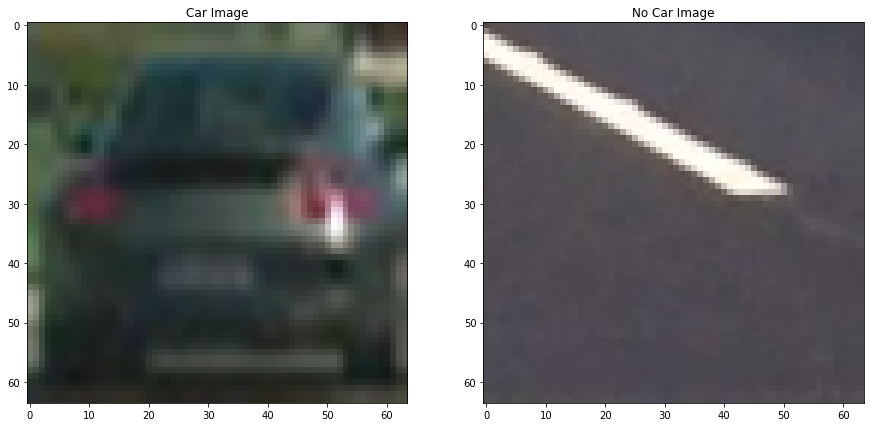

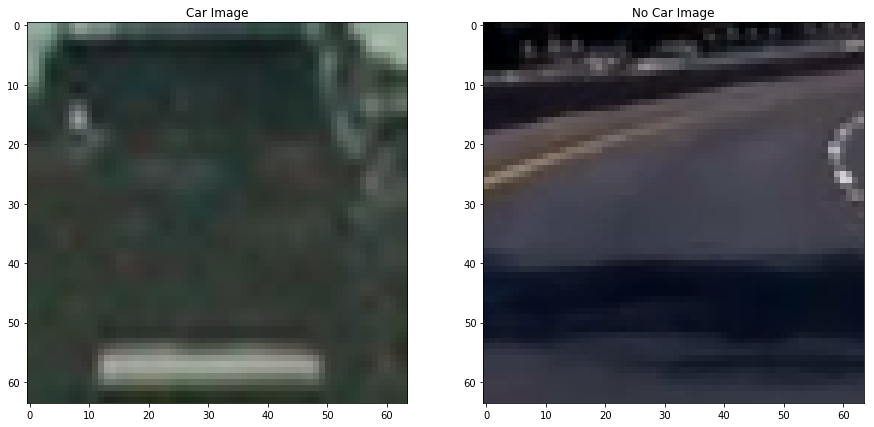

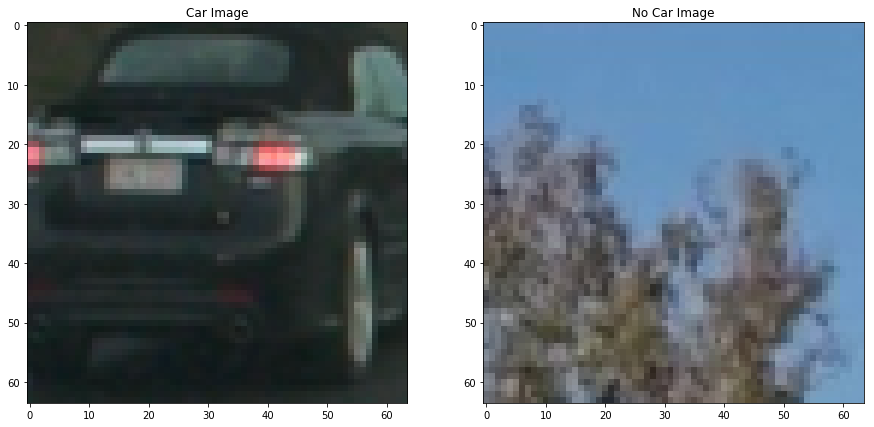

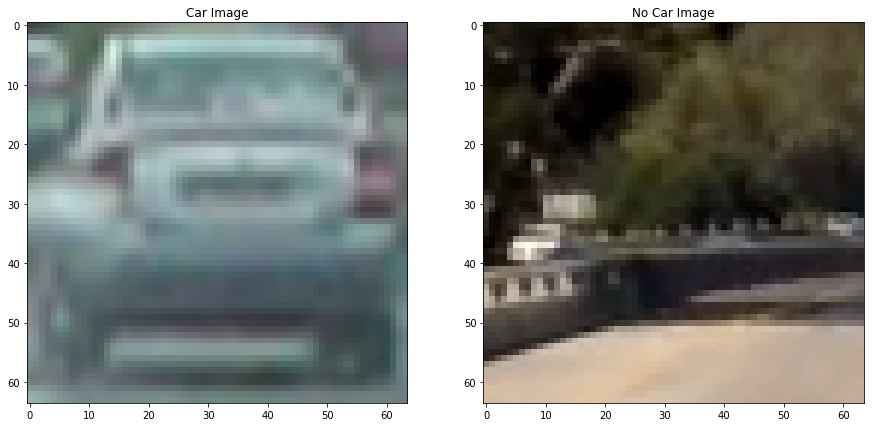

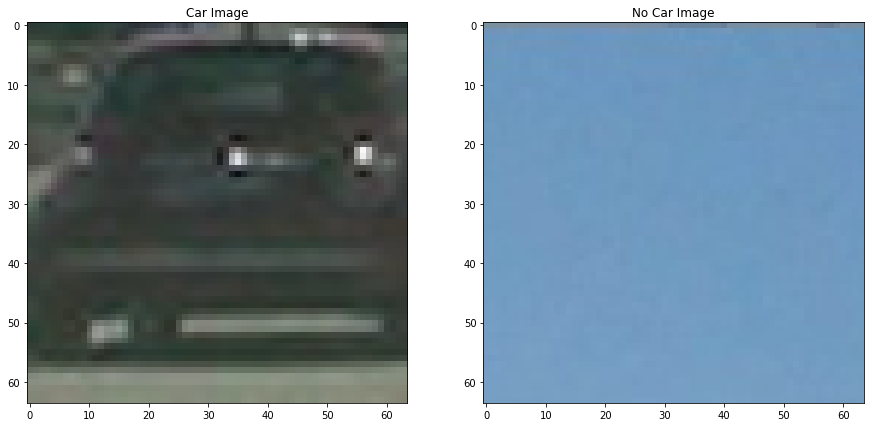

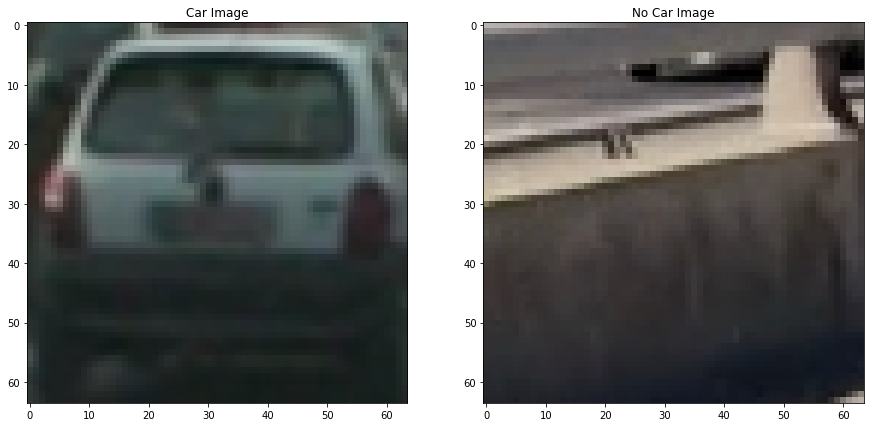

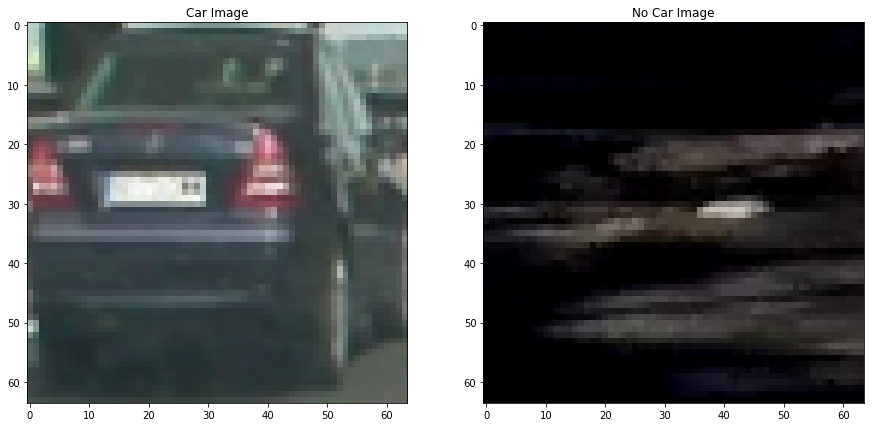

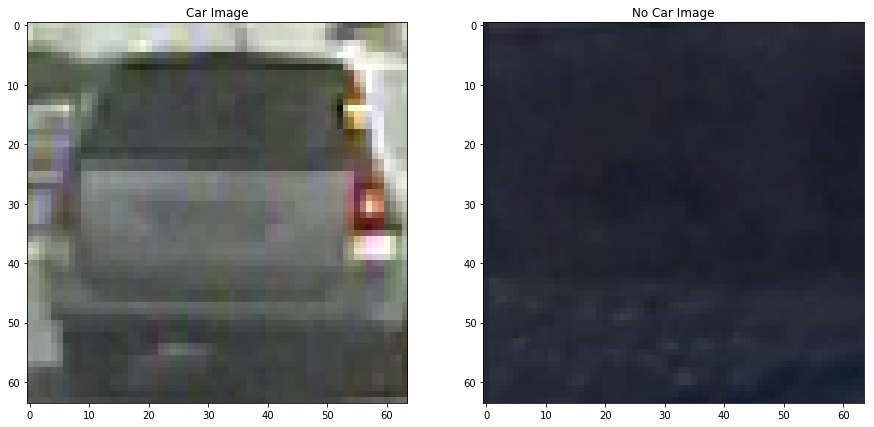

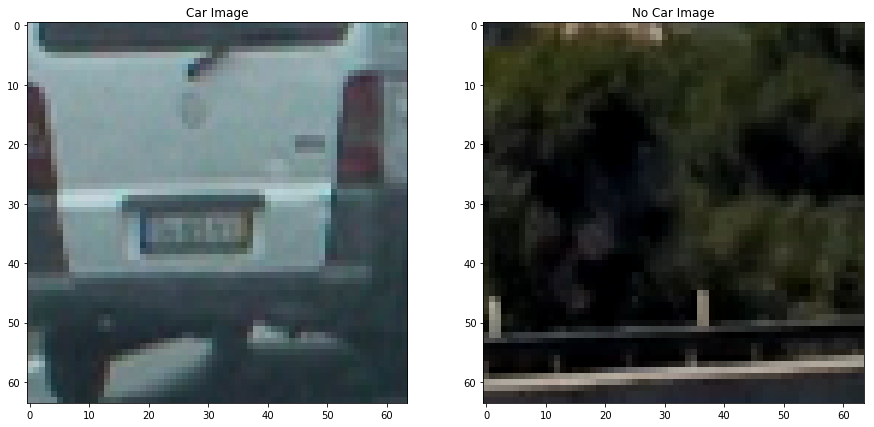

In [29]:
idx_list = np.random.randint(low=0, high=1000, size=10)

for idx in idx_list:
    car_img = read_image(car_path_list[idx])
    nocar_img = read_image(nocar_path_list[idx])
    
    plot_two_images(car_img, "Car Image", nocar_img, "No Car Image")

## Read datasets

In [4]:
def read_image(image_path, color_space=cv2.COLOR_BGR2RGB):
    """Returns an image in a given color space
    
    Args:
        image_path (str): /path/to/image.png
        color_space (:obj:cv2.COLOR_FLAG): (default: cv2.COLOR_BGR2RGB)
        
    Returns:
        3-D array: numpy image array (H, W, C)
    """
    
    img = cv2.imread(image_path)
    return cv2.cvtColor(img, color_space)

In [5]:
def read_image_multiprocess(image_path_list, color_space=cv2.COLOR_BGR2RGB):
    
    try:
        pool = Pool()
        tasks = [(image_path, color_space) for image_path in image_path_list]
        result = pool.starmap_async(read_image, tasks)
        
    finally:
        pool.close()
        pool.join()
        
        return np.array(result.get())

In [6]:
training_images = read_image_multiprocess(training_image_path_list)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(training_images, np.array(labels), train_size=0.75)

N_train = X_train.shape[0]
N_test = X_test.shape[0]

print("X_train.shape: {}".format(X_train.shape))
print("X_test.shape : {}".format(X_test.shape))

print("y_train.shape: {}".format(y_train.shape))
print("y_test.shape : {}".format(y_test.shape))

X_train.shape: (13320, 64, 64, 3)
X_test.shape : (4440, 64, 64, 3)
y_train.shape: (13320,)
y_test.shape : (4440,)


## Build a model

In [8]:
from keras.models import Model
from keras import layers
from keras.applications import vgg19
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras import backend as K

Using TensorFlow backend.


In [9]:
X = layers.Input(shape=(64, 64, 3), name="X")

In [10]:
def build_model(X, load_weights=False):
    X_processed = layers.Lambda(lambda x: x / K.max(x) - 1)(X)
    X_processed = layers.Convolution2D(3, (1, 1))(X_processed)
    
    vgg = vgg19.VGG19(include_top=False,
                      input_tensor=X_processed, weights=None)
    
    if load_weights:
        vgg_temp = vgg19.VGG19(include_top=False, weights="imagenet")
    
        for layer_a, layer_b in zip(vgg.layers[3:], vgg_temp.layers[1:]):
            layer_a.set_weights(layer_b.get_weights())
    
    net = vgg.output
    
    net = layers.Convolution2D(512, (2, 2))(net)
    net = layers.BatchNormalization()(net)
    net = layers.Activation("relu")(net)

    net = layers.Convolution2D(1024, (1, 1))(net)
    net = layers.BatchNormalization()(net)
    net = layers.Activation("relu")(net)

    net = layers.Convolution2D(1, (1, 1))(net)
    net = layers.Activation("sigmoid")(net)

    net = layers.Flatten()(net)
    
    return Model(inputs=X, outputs=net)

In [11]:
model = build_model(X)
model.compile("adam", "binary_crossentropy", ["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 64, 64, 3)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         12        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
__________

## Image Augmentations

In [12]:
train_gen = ImageDataGenerator(rotation_range=45.,
                               width_shift_range=0.3,
                               height_shift_range=0.3,
                               shear_range=0.5,
                               zoom_range=0.5,
                               channel_shift_range=0.0,                               
                               horizontal_flip=True)
test_gen = ImageDataGenerator()

train_flow = train_gen.flow(X_train, y_train, save_to_dir="augmented_images/")
test_flow = test_gen.flow(X_test, y_test)

## Train a model

In [13]:
callback_list = [callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
                 callbacks.ModelCheckpoint(filepath="model.h5", save_best_only=True, save_weights_only=True, mode="min")]

In [14]:
model.fit_generator(train_flow,
                    steps_per_epoch=N_train/32,
                    epochs=50,
                    validation_data=test_flow,                    
                    validation_steps=N_test/32, callbacks=callback_list)

Epoch 1/50
417/416 [==============================] - 43s - loss: 0.4416 - acc: 0.7796 - val_loss: 1.3645 - val_acc: 0.6365
Epoch 2/50
417/416 [==============================] - 41s - loss: 0.3033 - acc: 0.8692 - val_loss: 7.3505 - val_acc: 0.4966
Epoch 3/50
417/416 [==============================] - 41s - loss: 0.2416 - acc: 0.9001 - val_loss: 0.6225 - val_acc: 0.7023
Epoch 4/50
417/416 [==============================] - 40s - loss: 0.2182 - acc: 0.9132 - val_loss: 1.4553 - val_acc: 0.6065
Epoch 5/50
417/416 [==============================] - 41s - loss: 0.2032 - acc: 0.9182 - val_loss: 0.3993 - val_acc: 0.8856
Epoch 6/50
417/416 [==============================] - 40s - loss: 0.1701 - acc: 0.9337 - val_loss: 0.4253 - val_acc: 0.8836
Epoch 7/50
417/416 [==============================] - 41s - loss: 0.1555 - acc: 0.9393 - val_loss: 0.1186 - val_acc: 0.9543
Epoch 8/50
417/416 [==============================] - 40s - loss: 0.1456 - acc: 0.9450 - val_loss: 0.0856 - val_acc: 0.9671
Epoch 9/

## Save a model

In [15]:
model.save_weights("model.h5")

## ROI Cropping

In [16]:
def ROI_crop(image, height_range=(380, None), width_range=(None, None)):
    
    H, W, C = image.shape    
    H_beg, H_end = height_range
    W_beg, W_end = width_range
    
    if H_beg is None:
        H_beg = 0
    
    if W_beg is None:
        W_beg = 0
        
    if H_end is None:
        H_end = H
    
    if W_end is None:
        W_end = W
    
    return image[H_beg:H_end, W_beg:W_end, :]    

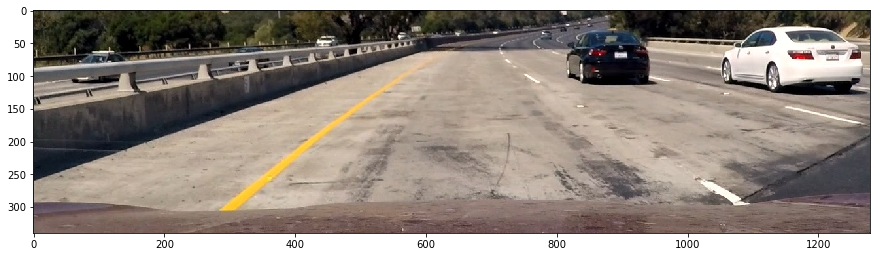

In [17]:
image = read_image("test_images/test1.jpg")

plt.figure(figsize=(15, 10))
cropped_image = ROI_crop(image)
plot_image(cropped_image)

In [18]:
print(image.shape)
print(cropped_image.shape)

(720, 1280, 3)
(340, 1280, 3)


## Build a heatmap model and load the pretrained weights

In [19]:
X = layers.Input(shape=cropped_image.shape, name="X")
heatmap_model = build_model(X)
heatmap_model = Model(inputs=X, outputs=heatmap_model.layers[-2].output)
heatmap_model.load_weights("./model.h5")
heatmap_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 340, 1280, 3)      0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 340, 1280, 3)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 340, 1280, 3)      12        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 340, 1280, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 340, 1280, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 170, 640, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 170, 640, 128)     73856     
__________

# Pipeline

## Pipeline factory

In [20]:
def pipeline_factory(model, confidence=0.99):
    
    def make_heatmap(pred, target_size):
        """Returns a heatmap from the prediction
        
        Since the prediction shape is small, 
        it should be rescaled back to the original size
        
        Args:
            pred (2-D array): predicted array (H, W)
            target_size (tuple): target size (int, int)
            
        Returns:
            2-D array: resized heat map
        """
        H_target, W_target = target_size
        H, W = pred.shape
        hh, ww = np.meshgrid(np.arange(H), np.arange(W), indexing="ij")
        
        heat_map = np.zeros((H, W))
        
        for i in np.arange(H):
            for j in np.arange(W):
                row = hh[i, j]
                col = ww[i, j]
                
                if pred[row, col] > confidence:
                    heat_map[row, col] += 1
        
        return cv2.resize(heat_map, (W_target, H_target), interpolation=cv2.INTER_LINEAR)
    
    
    def get_bboxes_from_labeled_heatmap(label_heatmap, labels):
        """Returns bbox from heatmap
        
        Args:
            label_heatmap (2-D array): heatmap array (H, W) it has labels from {1, 2, ..., n_objects}
            labels (int): number of objects in the heatmap
        
        Returns:
            bbox (list): each element is a tuple (`left_top`, `right_bot`)
                `left_top` is (col, row) or (x, y) coordinates                
        """
        bbox = []

        for label in range(labels):

            nonzero = np.nonzero(label_heatmap == label + 1)
            nonzero_row = nonzero[0]
            nonzero_col = nonzero[1]

            left_top = (min(nonzero_col), min(nonzero_row))
            right_bot = (max(nonzero_col), max(nonzero_row))

            bbox.append((left_top, right_bot))

        return bbox
    
    def draw_bboxes(image, bboxes, color=(0, 0, 255), thickness=6):
        """Returns bboxes drawn images

        Args:
            image (3-D array): numpy array (H, W, C)

            bboxes (list): each bbox consists of left-top coordinates and right-bottom coordinates

                For example, bboxes = [(`left_top`, `bottom_right`), (`left_top`, `bottom_right`), ... ]

                `left_top` = (COL, ROW). Notice it's not (ROW, COL)

        Returns:
            image (3-D array): bounding boxes are drawn on this image
        """
        image = np.copy(image)

        for left_top, right_bottom in bboxes:

            image = cv2.rectangle(image, left_top, right_bottom, color, thickness)

        return image
    
    def pipeline(input_image):
        """Returns an image with bounding boxes
        
        Args:
            input_image (3-D array): numpy RGB image, shape (H, W, C)
        
        Returns:
            image (3-D array): same shape as `input_image`,
                but bounding boxes are drawn over every detected object
        """
        shape = input_image.shape
        assert len(shape) == 3, shape
        
        cropped_image = ROI_crop(input_image)
        target_size = input_image.shape[:-1]
        
        image = np.expand_dims(cropped_image, 0)
        IMAGE_HEIGHT = image.shape[1]
        IMAGE_WIDTH = image.shape[2]
        
        pred = model.predict(image)
        pred = np.squeeze(pred)
        
        heat_map = make_heatmap(pred, (IMAGE_HEIGHT, IMAGE_WIDTH))
        heat_map, n_labels = label(heat_map)
        
        # cropped to uncropped size
        recovered = np.zeros(target_size)
        recovered[target_size[0] - IMAGE_HEIGHT:, :] = heat_map        
        
        bbox = get_bboxes_from_labeled_heatmap(recovered, n_labels)
        
        return draw_bboxes(input_image, bbox)
    
    
    return pipeline

## Pipeline Test

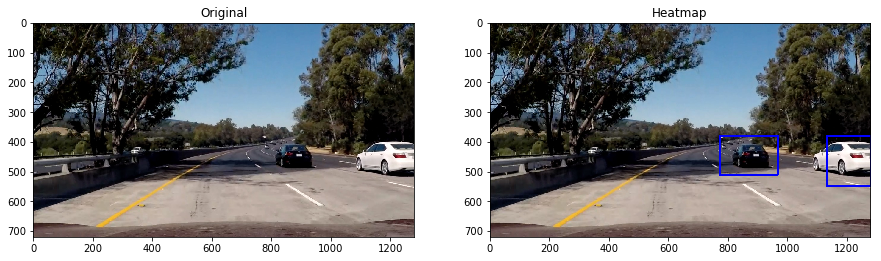

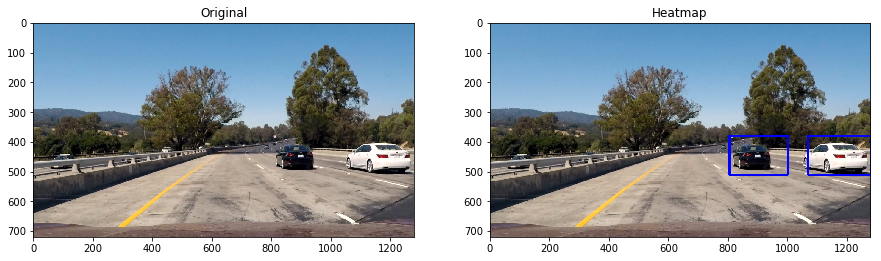

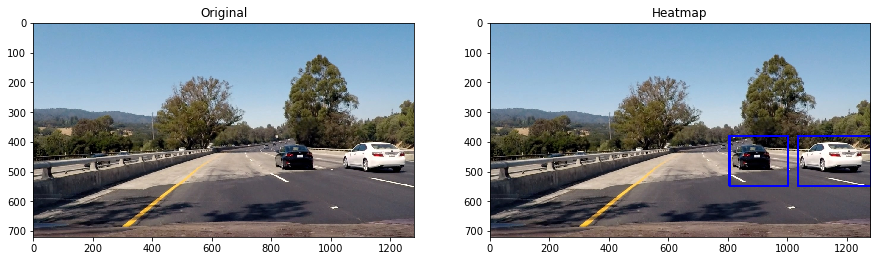

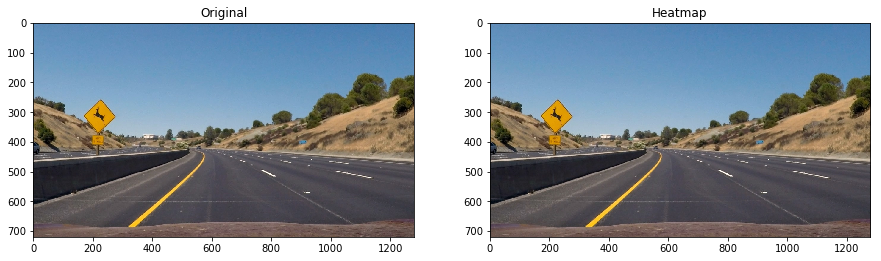

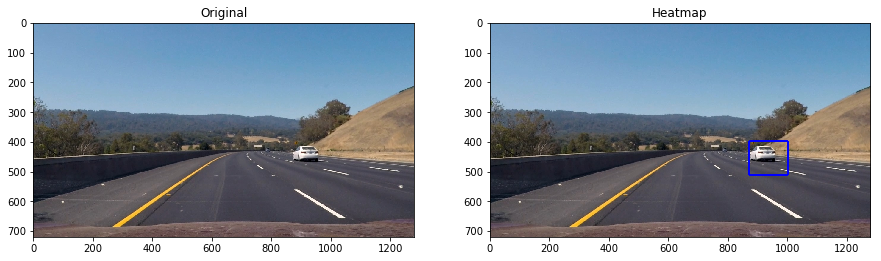

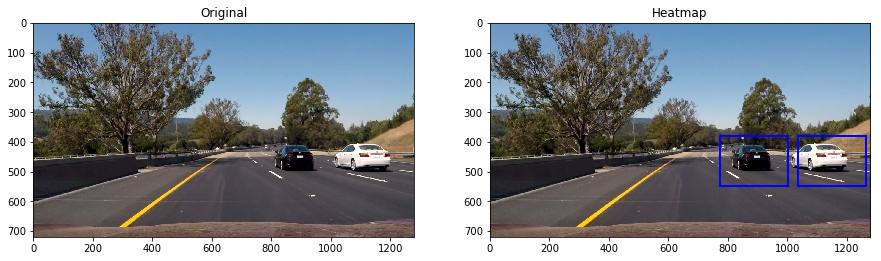

In [23]:
pipeline = pipeline_factory(heatmap_model, 0.99)

images = glob.glob("test_images/*.jpg")
for image in images:
    image = read_image(image)    
    plot_two_images(image, "Original", pipeline(image), "Heatmap")

## Video

In [24]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [27]:
output = 'out_dl.mp4'
clip = VideoFileClip("./project_video.mp4")
clip = clip.fl_image(pipeline)

%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out_dl.mp4
[MoviePy] Writing video out_dl.mp4


100%|█████████▉| 1260/1261 [01:25<00:00, 14.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_dl.mp4 

CPU times: user 1min 29s, sys: 21.9 s, total: 1min 51s
Wall time: 1min 25s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))